In [1]:
import sys
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/gaussfiltax')

import time

from jax import numpy as jnp
from jax import random as jr
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
# import tensorflow as tf
# tf.test.gpu_device_name()

import gaussfiltax.utils as utils
import gaussfiltax.inference as gf
from gaussfiltax.inference import ParamsUKF, _ukf_predict_nonadditive
from gaussfiltax.models import ParamsNLSSM, NonlinearSSM, ParamsBPF


import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Models and simulations

In [2]:
# Parameters
state_dim = 4
state_noise_dim = 2
emission_dim = 2
emission_noise_dim = 2
seq_length = 3*50
mu0 = 1.0 * jnp.array([-0.05, 0.001, 0.7, -0.05])
q0 = jnp.zeros(state_noise_dim)
r0 = jnp.zeros(emission_noise_dim)
Sigma0 = 1.0 * jnp.array([[0.1, 0.0, 0.0, 0.0],[0.0, 0.005, 0.0, 0.0],[0.0, 0.0, 0.1, 0.0],[0.0, 0.0, 0.0, 0.01]])
Q = 1e-5 * jnp.eye(state_noise_dim)
R = 25*1e-6 * jnp.eye(emission_noise_dim)

dt = 0.5
FCV = jnp.array([[1, dt, 0, 0],[0, 1, 0, 0],[0, 0, 1, dt],[0, 0, 0, 1]])
acc = 5
Omega = lambda x, acc: 0.1 * acc / jnp.sqrt(x[1]**2 + x[3]**2)
FCT =  lambda x, a: jnp.array([[1, jnp.sin(dt * Omega(x, a)) / Omega(x, a), 0, -(1-jnp.cos(dt * Omega(x, a))) / Omega(x, a)],
                            [0, jnp.cos(dt * Omega(x, a)), 0, -jnp.sin(dt * Omega(x, a))],
                            [0, (1-jnp.cos(dt * Omega(x, a))) / Omega(x, a), 1, jnp.sin(dt * Omega(x, a)) / Omega(x, a)],
                            [0, jnp.sin(dt * Omega(x, a)), 0, jnp.cos(dt * Omega(x, a))]])

G = jnp.array([[0.5, 0],[1, 0],[0, 0.5],[0, 1]])
fBOT = lambda x, q, u: FCV @ x + G @ q
fManBOT = lambda x, q, u: (0.5*(u-1)*(u-2)*FCV - u*(u-2)*FCT(x, acc) + 0.5*u*(u-1) * FCT(x, -acc)) @ x + G @ q
gBOT = lambda x, r, u: jnp.arctan2(x[2], x[0]) + r
gBOT2 = lambda x ,r, u: jnp.array([jnp.arctan2(x[2], x[0]), jnp.sqrt(x[0]**2 + x[2]**2)]) + r
gBOTlp = lambda x, y, u: MVN(loc = gBOT2(x, r0, u), covariance_matrix = R).log_prob(y)
# inputs = jnp.zeros((seq_length, 1))
inputs = jnp.array([1]*int(seq_length/3) + [0]*int(seq_length/3) + [2]*int(seq_length/3)) # maneuver inputs

In [3]:
f = fManBOT
g = gBOT2
glp = gBOTlp

In [4]:
# initialization
model = NonlinearSSM(state_dim, state_noise_dim, emission_dim, emission_noise_dim)
params = ParamsNLSSM(
    initial_mean=mu0,
    initial_covariance=Sigma0,
    dynamics_function=f,
    dynamics_noise_bias= q0,
    dynamics_noise_covariance=Q,
    emission_function=g,
    emission_noise_bias= r0,
    emission_noise_covariance=R,
)

## Experiments

sim 1/10
key0:  [3568232559  713140391]
key:  [3620866055 2761185182]
       Time taken for GSF:  1.0637030601501465
       Time taken for UGSF:  1.141272783279419
       Time taken for AGSF:  2.127995014190674
       Time taken for UAGSF:  1.9811289310455322
       Time taken for BPF:  1.2223753929138184
              GSF RMSE: 0.44058025
              UGSF RMSE: 0.44059694
              AGSF RMSE: 0.81678426
              UAGSF RMSE: 16.657503
              BPF RMSE: 0.43591157


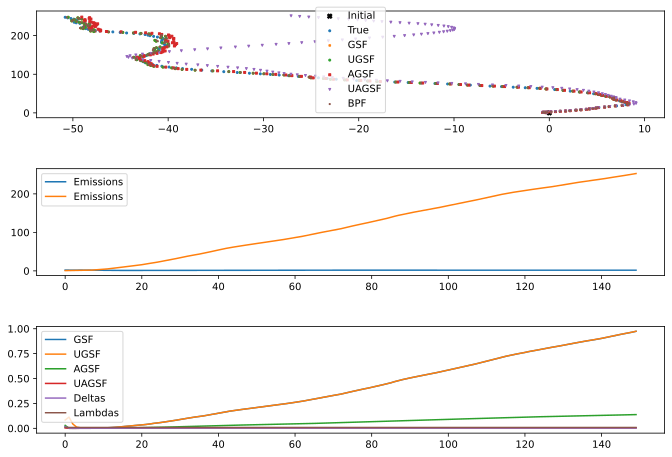

sim 2/10
key0:  [1465327881 3584627995]
key:  [1697684642 2171187924]
       Time taken for GSF:  0.8072199821472168
       Time taken for UGSF:  0.9678142070770264
       Time taken for AGSF:  1.8324060440063477
       Time taken for UAGSF:  1.8216159343719482
       Time taken for BPF:  0.9549999237060547
              GSF RMSE: nan
              UGSF RMSE: 0.3857383
              AGSF RMSE: 10.29796
              UAGSF RMSE: 3.7042146
              BPF RMSE: 0.3948678


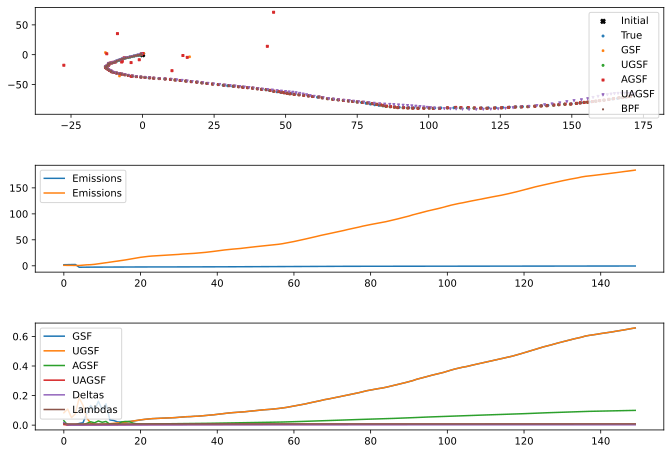

sim 3/10
key0:  [2140591709 3509555027]
key:  [704465164 725215309]
       Time taken for GSF:  0.7551469802856445
       Time taken for UGSF:  1.0504257678985596
       Time taken for AGSF:  1.8486418724060059
       Time taken for UAGSF:  1.793837070465088
       Time taken for BPF:  1.032092809677124
              GSF RMSE: 0.6044498
              UGSF RMSE: 0.6046724
              AGSF RMSE: 0.7089974
              UAGSF RMSE: 3.4728231
              BPF RMSE: 0.609356


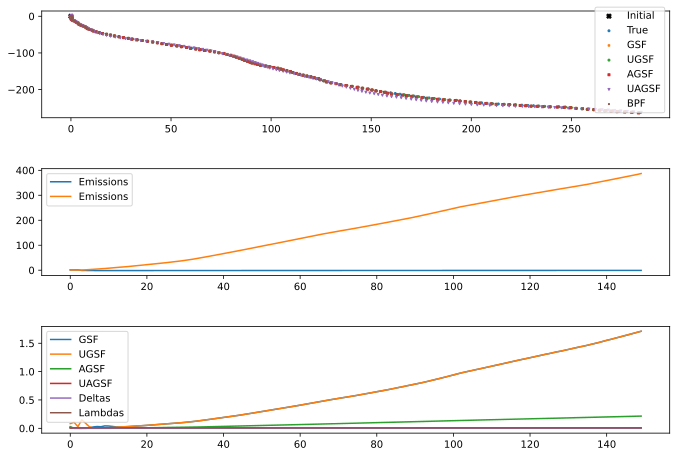

sim 4/10
key0:  [1303716432 1855432450]
key:  [2242020428 1473874242]
       Time taken for GSF:  0.7669517993927002
       Time taken for UGSF:  1.0639488697052002
       Time taken for AGSF:  1.8841516971588135
       Time taken for UAGSF:  1.7648701667785645


In [5]:
verbose = False
Nsim = 10
gsf_rmse = jnp.zeros(Nsim)
ugsf_rmse = jnp.zeros(Nsim)
agsf_rmse = jnp.zeros(Nsim)
uagsf_rmse = jnp.zeros(Nsim)
bpf_rmse = jnp.zeros(Nsim)

gsf_norm = jnp.zeros((Nsim, seq_length))
ugsf_norm = jnp.zeros((Nsim, seq_length))
agsf_norm = jnp.zeros((Nsim, seq_length))
uagsf_norm = jnp.zeros((Nsim, seq_length))
bpf_norm = jnp.zeros((Nsim, seq_length))

gsf_time = jnp.zeros(Nsim)
ugsf_time = jnp.zeros(Nsim)
agsf_time = jnp.zeros(Nsim)
uagsf_time = jnp.zeros(Nsim)
bpf_time = jnp.zeros(Nsim)
next_key = jr.PRNGKey(1)
for i in range(Nsim):
    print('sim {}/{}'.format(i+1, Nsim))
    # Generate Data
    key0, key, next_key = jr.split(next_key, 3)
    print('key0: ', key0)
    print('key: ', key)
    states, emissions = model.sample(params, key0, seq_length, inputs = inputs)

    # GSF
    M = 10
    tin = time.time()
    posterior_filtered_gsf = gf.gaussian_sum_filter(params, emissions, M, 1, inputs)
    point_estimate_gsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_gsf.means, posterior_filtered_gsf.weights), axis=0)
    tout = time.time()
    t_gsf= tout - tin
    print('       Time taken for GSF: ', tout - tin)

    # U-GSF
    tin = time.time()
    uparams = ParamsUKF(1,0,0)
    posterior_filtered_ugsf = gf.unscented_gaussian_sum_filter(params, uparams, emissions, M, 1, inputs)
    point_estimate_ugsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_ugsf.means, posterior_filtered_ugsf.weights), axis=0)
    tout = time.time()
    t_ugsf= tout - tin
    print('       Time taken for UGSF: ', tout - tin)

    # AGSF
    opt_args = (0.9, 0.9)
    num_components = [2, 2, 2]
    tin = time.time()
    posterior_filtered_agsf, aux_outputs = gf.speedy_augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)    
    point_estimate_agsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_agsf.means, posterior_filtered_agsf.weights), axis=0)
    tout = time.time()
    t_agsf= tout - tin
    print('       Time taken for AGSF: ', tout - tin)

    # U-AGSF
    tin = time.time()
    opt_args = (0.2, 0.2)
    num_components = [2, 2, 2]
    # posterior_filtered_uagsf, aux_outputs = gf.unscented_agsf(params, uparams, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)
    posterior_filtered_uagsf, aux_outputs = gf.speedy_augmented_gaussian_sum_filter(params, emissions, num_components, rng_key = key, opt_args = opt_args, inputs=inputs)
    point_estimate_uagsf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_filtered_uagsf.means, posterior_filtered_uagsf.weights), axis=0)
    tout = time.time()
    t_uagsf= tout - tin
    print('       Time taken for UAGSF: ', tout - tin)

    # BPF
    tin = time.time()
    num_particles = 10000

    params_bpf = ParamsBPF(
        initial_mean=mu0,
        initial_covariance=Sigma0,
        dynamics_function=f,
        dynamics_noise_bias=q0,
        dynamics_noise_covariance=Q,
        emission_function=g,
        emission_noise_bias=r0,
        emission_noise_covariance=R,
        emission_distribution_log_prob = glp
    )

    posterior_bpf = gf.bootstrap_particle_filter(params_bpf, emissions, num_particles, key, inputs, 1.0)
    point_estimate_bpf = jnp.sum(jnp.einsum('ijk,ij->ijk', posterior_bpf["particles"], posterior_bpf["weights"]), axis=0)
    tout = time.time()
    t_bpf = tout - tin
    print('       Time taken for BPF: ', tout - tin)

    # Computation of errors
    gsf_rmse = gsf_rmse.at[i].set(utils.rmse(point_estimate_gsf[:, (0,2)], states[:, (0,2)]))
    ugsf_rmse = ugsf_rmse.at[i].set(utils.rmse(point_estimate_ugsf[:, (0,2)], states[:, (0,2)]))
    agsf_rmse = agsf_rmse.at[i].set(utils.rmse(point_estimate_agsf[:, (0,2)], states[:, (0,2)]))
    uagsf_rmse = uagsf_rmse.at[i].set(utils.rmse(point_estimate_uagsf[:, (0,2)], states[:, (0,2)]))
    bpf_rmse = bpf_rmse.at[i].set(utils.rmse(point_estimate_bpf[:, (0,2)], states[:, (0,2)]))

    print('              GSF RMSE:', gsf_rmse[i])                                                                           
    print('              UGSF RMSE:', ugsf_rmse[i])
    print('              AGSF RMSE:', agsf_rmse[i])
    print('              UAGSF RMSE:', uagsf_rmse[i])
    print('              BPF RMSE:', bpf_rmse[i])

    gsf_norm = gsf_norm.at[i].set(jnp.linalg.norm(point_estimate_gsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    ugsf_norm = ugsf_norm.at[i].set(jnp.linalg.norm(point_estimate_ugsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    agsf_norm = agsf_norm.at[i].set(jnp.linalg.norm(point_estimate_agsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    uagsf_norm = uagsf_norm.at[i].set(jnp.linalg.norm(point_estimate_uagsf[:,(0,2)] - states[:,(0,2)], axis = 1))
    bpf_norm = bpf_norm.at[i].set(jnp.linalg.norm(point_estimate_bpf[:,(0,2)] - states[:,(0,2)], axis = 1))

    gsf_time = gsf_time.at[i].set(t_gsf)
    ugsf_time = ugsf_time.at[i].set(t_ugsf)
    agsf_time = agsf_time.at[i].set(t_agsf)
    uagsf_time = uagsf_time.at[i].set(t_uagsf)
    bpf_time = bpf_time.at[i].set(t_bpf)

    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 7))
    fig.tight_layout(pad=3.0)
    axes[0].scatter(jnp.array([0]), jnp.array([0]), label = 'Initial', s = 20, marker = 'X', color = 'black')
    axes[0].scatter(states[:,0], states[:,2], label = 'True', s = 4)
    axes[0].scatter(point_estimate_gsf[:,0], point_estimate_gsf[:,2], label = 'GSF', s = 4, marker = 'x')
    axes[0].scatter(point_estimate_ugsf[:,0], point_estimate_ugsf[:,2], label = 'UGSF', s = 4, marker = 'o')
    axes[0].scatter(point_estimate_agsf[:,0], point_estimate_agsf[:,2], label = 'AGSF', s = 4, marker = 's')
    axes[0].scatter(point_estimate_uagsf[:,0], point_estimate_uagsf[:,2], label = 'UAGSF', s = 4, marker = 'v')
    axes[0].scatter(point_estimate_bpf[:,0], point_estimate_bpf[:,2], label = 'BPF', s = 4, marker = '+')
    axes[0].legend()   

    axes[1].plot(emissions, label = 'Emissions')
    axes[1].legend()

    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_gsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'GSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_ugsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'UGSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_agsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'AGSF')
    axes[2].plot(jnp.sum(jnp.trace(posterior_filtered_uagsf.covariances, axis1=2, axis2=3), axis=0)/M, label = 'UAGSF')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Deltas'], axis1=2, axis2=3), axis=1)/5, label = 'Deltas')
    axes[2].plot(jnp.sum(jnp.trace(aux_outputs['Lambdas'], axis1=2, axis2=3), axis=1)/25, label = 'Lambdas')
    axes[2].legend()

 

    plt.show()

In [ ]:
import pandas as pd
def bootstrap(key, rmse_array, B):
    N = rmse_array.shape[0]
    rmse_boot = jnp.zeros((B,))
    for b in range(B):
        key, subkey = jr.split(key)
        ind = jr.randint(subkey, (N,), 0, N)
        rmse_boot = rmse_boot.at[b].set(jnp.mean(rmse_array[ind]))
    return rmse_boot

keys = jr.split(jr.PRNGKey(0), 5)
B = 100
gsf_boot = bootstrap(keys[0], gsf_rmse, B)
ugsf_boot = bootstrap(keys[1], ugsf_rmse, B)
agsf_boot = bootstrap(keys[2], agsf_rmse, B)
uagsf_boot = bootstrap(keys[3], uagsf_rmse, B)
bpf_boot = bootstrap(keys[4], bpf_rmse, B)


gsf_armse = jnp.mean(gsf_boot)
ugsf_armse = jnp.mean(ugsf_boot)
agsf_armse = jnp.mean(agsf_boot)
uagsf_armse = jnp.mean(uagsf_boot)
bpf_armse = jnp.mean(bpf_boot)

# gsf_armse = jnp.mean(gsf_rmse)
# ugsf_armse = jnp.mean(ugsf_rmse)
# agsf_armse = jnp.mean(agsf_rmse)
# uagsf_armse = jnp.mean(uagsf_rmse)
# bpf_armse = jnp.mean(bpf_rmse)

gsf_atime = jnp.mean(gsf_time)
ugsf_atime = jnp.mean(ugsf_time)
agsf_atime = jnp.mean(agsf_time)
uagsf_atime = jnp.mean(uagsf_time)
bpf_atime = jnp.mean(bpf_time)

gsf_tab_out = '{:10.2f}±{:10.2f}'.format(gsf_armse, jnp.std(gsf_boot))
ugsf_tab_out = '{:10.2f}±{:10.2f}'.format(ugsf_armse, jnp.std(ugsf_boot))
agsf_tab_out = '{:10.2f}±{:10.2f}'.format(agsf_armse, jnp.std(agsf_boot))
uagsf_tab_out = '{:10.2f}±{:10.2f}'.format(uagsf_armse, jnp.std(uagsf_boot))
bpf_tab_out = '{:10.2f}±{:10.2f}'.format(bpf_armse, jnp.std(bpf_boot))

gsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(gsf_atime, jnp.std(gsf_time))
ugsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(ugsf_atime, jnp.std(ugsf_time))
agsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(agsf_atime, jnp.std(agsf_time))
uagsf_tab_out1 = '{:10.2f}±{:10.2f}'.format(uagsf_atime, jnp.std(uagsf_time))
bpf_tab_out1 = '{:10.2f}±{:10.2f}'.format(bpf_atime, jnp.std(bpf_time))

df = pd.DataFrame(columns = [' ','RMSE','time(s)'])
# df[' '] = ['GSF', 'AGSF', 'AGSF Optimal', 'BPF']
# df['RMSE'] = [gsf_tab_out, agsf_tab_out, agsf_opt_tab_out, bpf_tab_out]
# df['time(s)'] = [gsf_tab_out1, agsf_tab_out1, agsf_opt_tab_out1, bpf_tab_out1]
df[' '] = ['GSF','UGSF', 'AGSF', 'UAGSF', 'BPF']
df['RMSE'] = [gsf_tab_out, ugsf_tab_out, agsf_tab_out, uagsf_tab_out, bpf_tab_out]
df['time(s)'] = [gsf_tab_out1, ugsf_tab_out1, agsf_tab_out1, uagsf_tab_out1, bpf_tab_out1]
print(df.to_latex(index=False))
df

\begin{tabular}{lll}
\toprule
  & RMSE & time(s) \\
\midrule
GSF &        nan±       nan &       0.90±      0.29 \\
UGSF &       0.02±      0.00 &       1.17±      0.45 \\
AGSF &       0.04±      0.01 &       2.02±      0.41 \\
UAGSF &       0.99±      0.16 &       1.94±      0.29 \\
BPF &       0.30±      0.09 &       0.96±      0.11 \\
\bottomrule
\end{tabular}



,,RMSE,time(s)
0,GSF,nan± nan,0.90± 0.29
1,UGSF,0.02± 0.00,1.17± 0.45
2,AGSF,0.04± 0.01,2.02± 0.41
3,UAGSF,0.99± 0.16,1.94± 0.29
4,BPF,0.30± 0.09,0.96± 0.11
